In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import ParameterGrid



###################################
#
#
#
#     FILE PATH
#
#
#
####################################
############################################################
df = pd.read_csv("data/NF-UNSW-NB15.csv")
############################################################
print("Basic Info:\n", df.info())
print("First 5 rows:\n", df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1623118 entries, 0 to 1623117
Data columns (total 14 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   IPV4_SRC_ADDR               1623118 non-null  object 
 1   L4_SRC_PORT                 1623118 non-null  int64  
 2   IPV4_DST_ADDR               1623118 non-null  object 
 3   L4_DST_PORT                 1623118 non-null  int64  
 4   PROTOCOL                    1623118 non-null  int64  
 5   L7_PROTO                    1623118 non-null  float64
 6   IN_BYTES                    1623118 non-null  int64  
 7   OUT_BYTES                   1623118 non-null  int64  
 8   IN_PKTS                     1623118 non-null  int64  
 9   OUT_PKTS                    1623118 non-null  int64  
 10  TCP_FLAGS                   1623118 non-null  int64  
 11  FLOW_DURATION_MILLISECONDS  1623118 non-null  int64  
 12  Label                       1623118 non-null  int64  
 1

IPV4_SRC_ADDR                 0
L4_SRC_PORT                   0
IPV4_DST_ADDR                 0
L4_DST_PORT                   0
PROTOCOL                      0
L7_PROTO                      0
IN_BYTES                      0
OUT_BYTES                     0
IN_PKTS                       0
OUT_PKTS                      0
TCP_FLAGS                     0
FLOW_DURATION_MILLISECONDS    0
Label                         0
Attack                        0
dtype: int64
Attack
Benign            1550712
Exploits            24736
Fuzzers             19463
Reconnaissance      12291
Generic              5570
DoS                  5051
Analysis             1995
Backdoor             1782
Shellcode            1365
Worms                 153
Name: count, dtype: int64


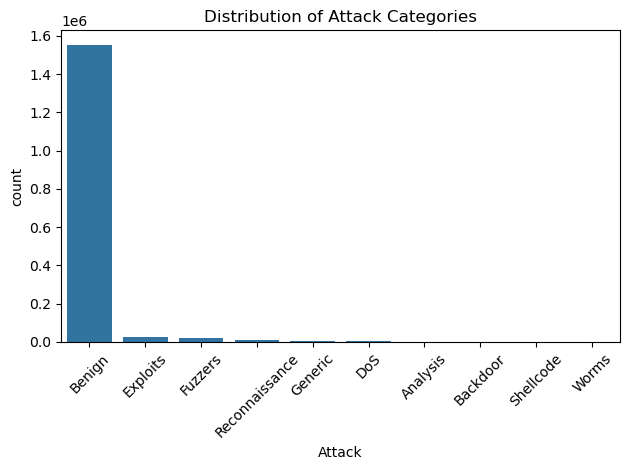

Negative values in IN_BYTES: 0


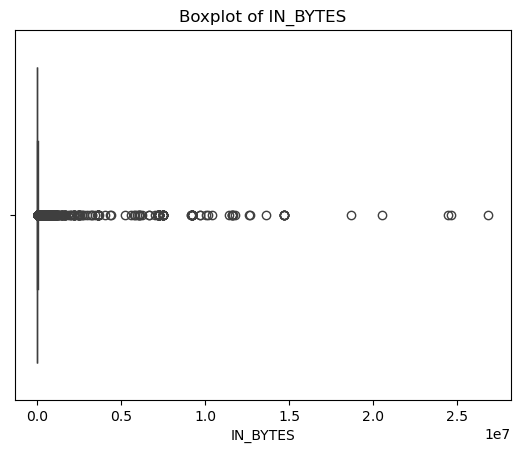

Negative values in OUT_BYTES: 0


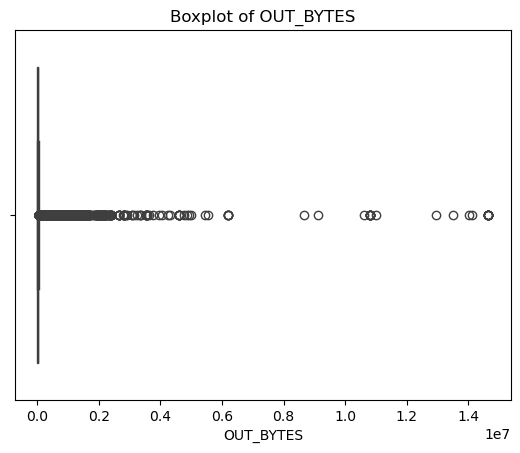

Negative values in IN_PKTS: 0


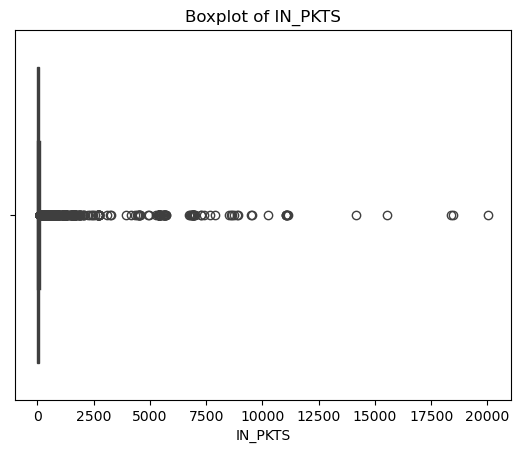

Negative values in OUT_PKTS: 0


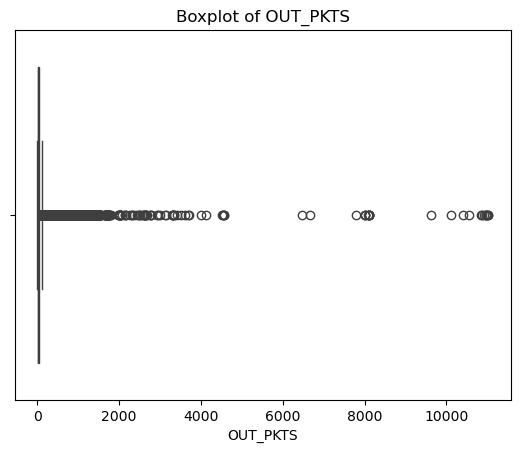

Negative values in FLOW_DURATION_MILLISECONDS: 0


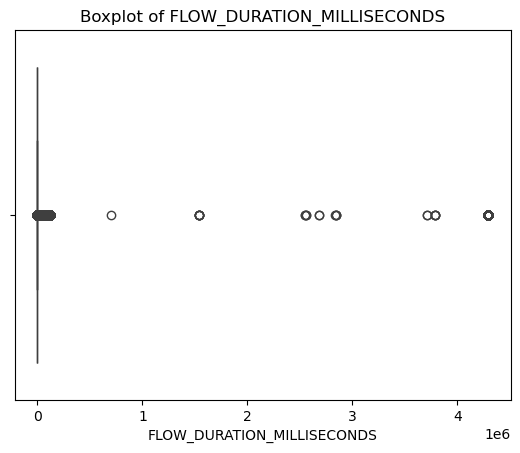

                            L4_SRC_PORT  L4_DST_PORT  PROTOCOL  L7_PROTO  \
L4_SRC_PORT                    1.000000     0.030727 -0.116602 -0.008694   
L4_DST_PORT                    0.030727     1.000000 -0.156159  0.133112   
PROTOCOL                      -0.116602    -0.156159  1.000000 -0.112017   
L7_PROTO                      -0.008694     0.133112 -0.112017  1.000000   
IN_BYTES                      -0.001544    -0.017243 -0.019492  0.002343   
OUT_BYTES                      0.000475    -0.039697 -0.075392  0.075795   
IN_PKTS                        0.000056     0.003157 -0.126623  0.167771   
OUT_PKTS                       0.001323    -0.034713 -0.115350  0.136146   
TCP_FLAGS                      0.020061     0.295358 -0.490953  0.241509   
FLOW_DURATION_MILLISECONDS    -0.002213    -0.045799 -0.031195 -0.032112   
Label                         -0.048061    -0.129065  0.284834  0.017352   

                            IN_BYTES  OUT_BYTES   IN_PKTS  OUT_PKTS  \
L4_SRC_PORT     

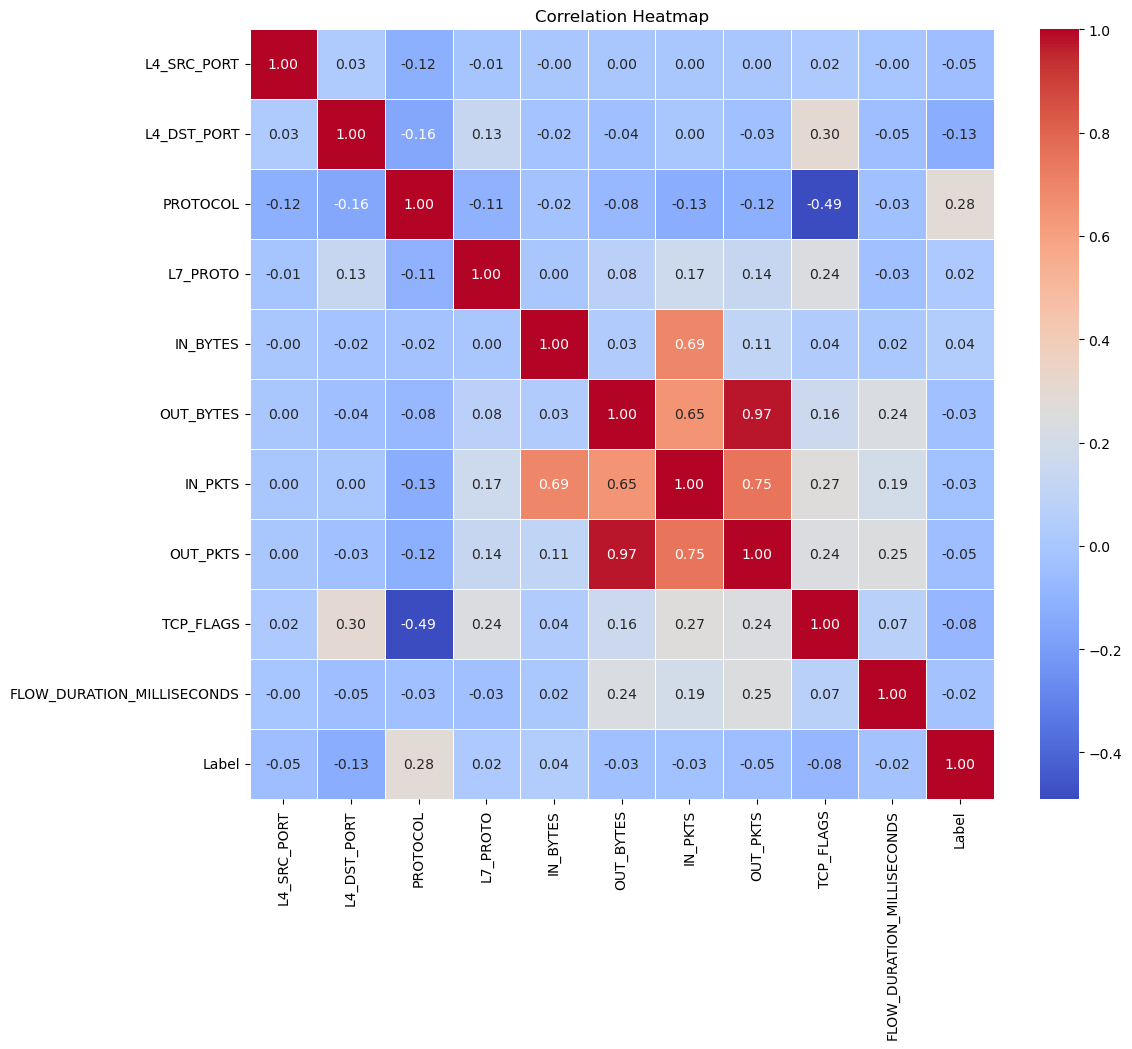

In [ ]:
print(df.isnull().sum())
print(df['Attack'].value_counts())
sns.countplot(data=df, x='Attack', order=df['Attack'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribution of Attack Categories')
plt.tight_layout()
plt.show()

non_negative_cols = [
    'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS',
    'FLOW_DURATION_MILLISECONDS'
]
for col in non_negative_cols:
    neg_count = (df[col] < 0).sum()
    print(f"Negative values in {col}: {neg_count}")
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

df.describe()

correlation_matrix = df.corr(numeric_only=True)
print(correlation_matrix)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
def common_prep(df):
    """
    Drops universally useless or leak-prone columns,
    e.g. OUT_BYTES (and any others you decide).
    """
    df = df.copy()
    df.drop(columns=['OUT_BYTES'], inplace=True, errors='ignore')
    return df


In [ ]:
def add_ip_freq_pct(df_tr, df_use):
    """
    Compute raw-IP frequency percentage on df_tr,
    then map it onto df_use, unseen→0.
    """
    n = len(df_tr)
    counts = df_tr['IPV4_SRC_ADDR'].value_counts().to_dict()
    df_use['SRC_IP_FREQ_PCT'] = (
        df_use['IPV4_SRC_ADDR']
           .map(counts).fillna(0)
           .div(n)
    )
    counts = df_tr['IPV4_DST_ADDR'].value_counts().to_dict()
    df_use['DST_IP_FREQ_PCT'] = (
        df_use['IPV4_DST_ADDR']
           .map(counts).fillna(0)
           .div(n)
    )
    return df_use
def add_subnet_freq_pct(df_tr, df_use):
    """
    Compute /24-subnet frequency percentage on df_tr,
    then map it onto df_use, unseen→0.
    """
    n = len(df_tr)

    tr_src_sub = df_tr['IPV4_SRC_ADDR'].str.rsplit('.', n=1).str[0]
    tr_dst_sub = df_tr['IPV4_DST_ADDR'].str.rsplit('.', n=1).str[0]

    src_counts = tr_src_sub.value_counts().to_dict()
    dst_counts = tr_dst_sub.value_counts().to_dict()

    df_use['SRC_SUBNET_FREQ_PCT'] = (
        df_use['IPV4_SRC_ADDR']
           .str.rsplit('.', n=1).str[0]
           .map(src_counts).fillna(0)
           .div(n)
    )
    df_use['DST_SUBNET_FREQ_PCT'] = (
        df_use['IPV4_DST_ADDR']
           .str.rsplit('.', n=1).str[0]
           .map(dst_counts).fillna(0)
           .div(n)
    )
    return df_use



In [ ]:
def make_raw_all(df):
    df1 = common_prep(df)
    df1.drop(columns=['IPV4_SRC_ADDR','IPV4_DST_ADDR'], inplace=True)
    return df1


In [ ]:



def make_ip_octets_and_freqs(df):
    df1 = common_prep(df)

    for ip in ['IPV4_SRC_ADDR','IPV4_DST_ADDR']:
        for i in range(4):
            df1[f"{ip}_octet{i+1}"] = (
                df1[ip].str.split('.', expand=True)[i].astype(int)
            )
    df1 = add_ip_freq_pct(df, df1)
    df1.drop(columns=['IPV4_SRC_ADDR','IPV4_DST_ADDR'], inplace=True)
    return df1


In [31]:
def make_subnet_freqs_only(df):
    df1 = common_prep(df)
    df1 = add_subnet_freq_pct(df, df1)
    df1.drop(columns=['IPV4_SRC_ADDR','IPV4_DST_ADDR'], inplace=True)
    return df1

In [32]:
def make_no_ip_raw_numeric(df):
    df1 = common_prep(df)
    df1.drop(columns=['IPV4_SRC_ADDR','IPV4_DST_ADDR'], inplace=True)
    return df1


In [33]:
def make_transformed_numeric(df):
    df1 = common_prep(df)
    nums = ['IN_BYTES','IN_PKTS','OUT_PKTS','FLOW_DURATION_MILLISECONDS']
    for c in nums:
        df1[c+'_log'] = np.log1p(df1[c])
    from sklearn.preprocessing import RobustScaler
    rsc = RobustScaler().fit(df1[nums + [c+'_log' for c in nums]])
    df1[nums + [c+'_log' for c in nums]] = rsc.transform(df1[nums + [c+'_log' for c in nums]])
    df1.drop(columns=nums, inplace=True)
    df1.drop(columns=['IPV4_SRC_ADDR','IPV4_DST_ADDR'], inplace=True)
    return df1

In [34]:
def make_balanced(df):
    benign = df[df['Label']==0]
    attack = df[df['Label']==1]
    benign_down = benign.sample(n=len(attack), random_state=42)
    return pd.concat([benign_down, attack]).sample(frac=1, random_state=42)


In [ ]:
df_temp, df_test = train_test_split(
    df,
    test_size=0.25,
    random_state=42,
    stratify=df['Label']
)
df_train, df_val = train_test_split(
    df_temp,
    test_size=1/3,
    random_state=42,
    stratify=df_temp['Label']
)

builders = {
    'raw_all_features':        make_raw_all,
    'ip_octets_and_freqs':     make_ip_octets_and_freqs,
    'subnet_freqs_only':       make_subnet_freqs_only,
    'no_ip_raw_numeric':       make_no_ip_raw_numeric,
}

data_versions_train = {
    name: fn(df_train) for name, fn in builders.items()
}
data_versions_val = {
    name: fn(df_val) for name, fn in builders.items()
}


In [50]:
print("Builders:", list(builders.keys()))


Builders: ['raw_all_features', 'ip_octets_and_freqs', 'subnet_freqs_only', 'no_ip_raw_numeric']


In [ ]:
X_train_versions = {}
y_train_versions = {}
X_val_versions   = {}
y_val_versions   = {}

for name, dft in data_versions_train.items():
    X_train_versions[name] = dft.drop(columns=["Attack", "Label"])
    y_train_versions[name] = dft["Label"]

for name, dfv in data_versions_val.items():
    X_val_versions[name] = dfv.drop(columns=["Attack", "Label"])
    y_val_versions[name] = dfv["Label"]

models = {}
for version in X_train_versions:
    rf = RandomForestClassifier(
        random_state=42,
        n_jobs=-1         
    )
    rf.fit(
        X_train_versions[version],
        y_train_versions[version]
    )
    models[version] = rf

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import pandas as pd

results = []

for version, rf in models.items():
    Xvl = X_val_versions[version]
    yvl = y_val_versions[version]
    
    y_pred  = rf.predict(Xvl)
    y_proba = rf.predict_proba(Xvl)[:, 1]
    
    acc  = accuracy_score(yvl, y_pred)
    f1m  = f1_score(yvl, y_pred, average="macro")
    auc  = roc_auc_score(yvl, y_proba)
    
    print(f"--- {version} ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Macro F1 : {f1m:.4f}")
    print(f"ROC AUC  : {auc:.4f}")
    print(classification_report(yvl, y_pred, digits=4))
    
    results.append({
        "version":  version,
        "accuracy": acc,
        "f1_macro": f1m,
        "roc_auc":  auc
    })

df_results = pd.DataFrame(results).set_index("version")
print("\nSummary table:")
print(df_results)



--- raw_all_features ---
Accuracy : 0.9889
Macro F1 : 0.9349
ROC AUC  : 0.9958
              precision    recall  f1-score   support

           0     0.9940    0.9944    0.9942    387679
           1     0.8791    0.8723    0.8757     18101

    accuracy                         0.9889    405780
   macro avg     0.9366    0.9333    0.9349    405780
weighted avg     0.9889    0.9889    0.9889    405780

--- ip_octets_and_freqs ---
Accuracy : 0.9913
Macro F1 : 0.9489
ROC AUC  : 0.9968
              precision    recall  f1-score   support

           0     0.9954    0.9955    0.9954    387679
           1     0.9031    0.9016    0.9023     18101

    accuracy                         0.9913    405780
   macro avg     0.9493    0.9485    0.9489    405780
weighted avg     0.9913    0.9913    0.9913    405780

--- subnet_freqs_only ---
Accuracy : 0.9891
Macro F1 : 0.9357
ROC AUC  : 0.9961
              precision    recall  f1-score   support

           0     0.9941    0.9945    0.9943    387

In [49]:
from sklearn.metrics import accuracy_score, roc_auc_score

for version, rf in models.items():
    Xtr, ytr = X_train_versions[version], y_train_versions[version]
    Xvl, yvl = X_val_versions[version],   y_val_versions[version]

    # Train‐set performance
    ytr_pred  = rf.predict(Xtr)
    ytr_proba = rf.predict_proba(Xtr)[:,1]
    train_acc = accuracy_score(ytr, ytr_pred)
    train_auc = roc_auc_score(ytr, ytr_proba)

    # Validation‐set performance
    yvl_pred  = rf.predict(Xvl)
    yvl_proba = rf.predict_proba(Xvl)[:,1]
    val_acc   = accuracy_score(yvl, yvl_pred)
    val_auc   = roc_auc_score(yvl, yvl_proba)

    print(f"{version:20s} Train AUC: {train_auc:.4f}, Val AUC: {val_auc:.4f}")



raw_all_features     Train AUC: 1.0000, Val AUC: 0.9958
ip_octets_and_freqs  Train AUC: 1.0000, Val AUC: 0.9968
subnet_freqs_only    Train AUC: 1.0000, Val AUC: 0.9961
no_ip_raw_numeric    Train AUC: 1.0000, Val AUC: 0.9958
transformed_numeric  Train AUC: 1.0000, Val AUC: 0.9925


min_samples_leaf =    1 → ROC AUC = 0.9977
min_samples_leaf =    2 → ROC AUC = 0.9977
min_samples_leaf =    5 → ROC AUC = 0.9977
min_samples_leaf =   10 → ROC AUC = 0.9977
min_samples_leaf =   20 → ROC AUC = 0.9977
min_samples_leaf =   50 → ROC AUC = 0.9977
min_samples_leaf =  100 → ROC AUC = 0.9977
min_samples_leaf =  200 → ROC AUC = 0.9976
min_samples_leaf =  500 → ROC AUC = 0.9972
min_samples_leaf = 1000 → ROC AUC = 0.9967


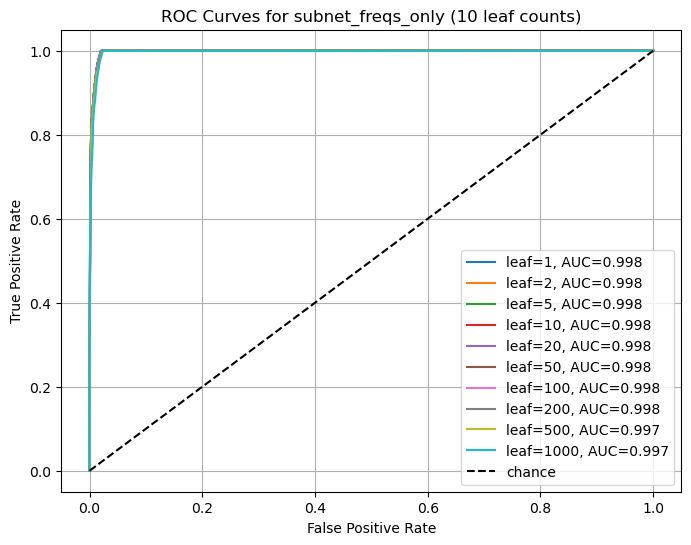

In [53]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

df_temp, df_test = train_test_split(
    df, test_size=0.25, random_state=42, stratify=df['Label']
)
df_train, df_val = train_test_split(
    df_temp, test_size=1/3, random_state=42, stratify=df_temp['Label']
)

df_train_subnet = make_subnet_freqs_only(df_train)
df_val_subnet   = make_subnet_freqs_only(df_val)

X_train = df_train_subnet.drop(columns=["Attack", "Label"])
y_train = df_train_subnet["Label"]
X_val   = df_val_subnet.drop(columns=["Attack", "Label"])
y_val   = df_val_subnet["Label"]

base_params = {
    "n_estimators":   200,
    "max_depth":      12,
    "max_leaf_nodes": 50,
    "n_jobs":        -1,
    "random_state":  42,
}

leaf_counts = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

plt.figure(figsize=(8, 6))
for leaf in leaf_counts:
    params = {**base_params, "min_samples_leaf": leaf}
    rf = RandomForestClassifier(**params)
    rf.fit(X_train, y_train)

    y_proba = rf.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    auc = roc_auc_score(y_val, y_proba)

    plt.plot(fpr, tpr, label=f"leaf={leaf}, AUC={auc:.3f}")
    print(f"min_samples_leaf = {leaf:4d} → ROC AUC = {auc:.4f}")

plt.plot([0, 1], [0, 1], "k--", label="chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for subnet_freqs_only (10 leaf counts)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

df_temp, df_test = train_test_split(
    df, test_size=0.25, random_state=42, stratify=df['Label']
)
df_train, df_val = train_test_split(
    df_temp, test_size=1/3, random_state=42, stratify=df_temp['Label']
)

df_tr = make_subnet_freqs_only(df_train)
df_vl = make_subnet_freqs_only(df_val)
X_tr = df_tr.drop(columns=["Attack","Label"])
y_tr = df_tr["Label"]
X_vl = df_vl.drop(columns=["Attack","Label"])
y_vl = df_vl["Label"]

depths = [4, 8, 12, 16, 20]
leaf_nodes = [10, 25, 50, 100, 200]

results = []
for depth in depths:
    for leaves in leaf_nodes:
        rf = RandomForestClassifier(
            n_estimators=200,
            max_depth=depth,
            max_leaf_nodes=leaves,
            n_jobs=-1,
            random_state=42
        )
        rf.fit(X_tr, y_tr)
        y_proba = rf.predict_proba(X_vl)[:,1]
        auc = roc_auc_score(y_vl, y_proba)
        results.append({
            "max_depth":      depth,
            "max_leaf_nodes": leaves,
            "roc_auc":        auc
        })




    max_depth  max_leaf_nodes   roc_auc
24         20             200  0.997948
19         16             200  0.997945
14         12             200  0.997882
23         20             100  0.997870
18         16             100  0.997869
13         12             100  0.997828
17         16              50  0.997715
22         20              50  0.997715
12         12              50  0.997710
9           8             200  0.997559


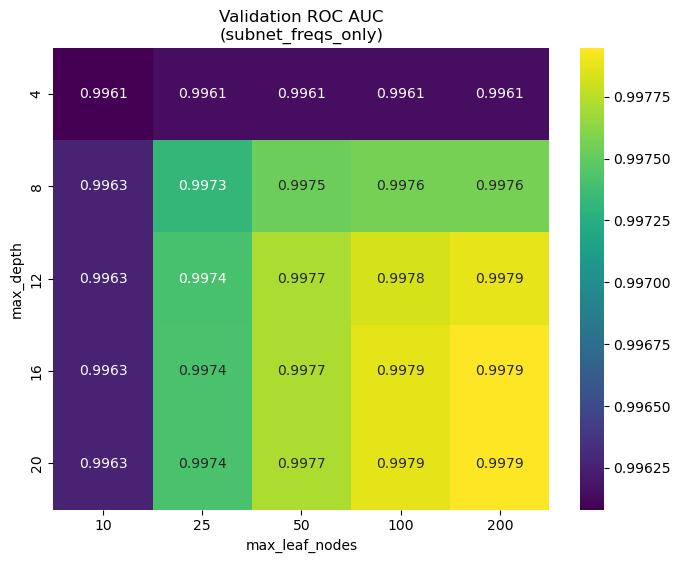

In [ ]:
df_grid = pd.DataFrame(results)
pivot = df_grid.pivot(
    index="max_depth",
    columns="max_leaf_nodes",
    values="roc_auc"
)

print(df_grid.sort_values("roc_auc", ascending=False).head(10))

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".4f", cmap="viridis")
plt.title("Validation ROC AUC\n(subnet_freqs_only)")
plt.ylabel("max_depth")
plt.xlabel("max_leaf_nodes")
plt.show()

In [67]:
df_train_subnet = make_subnet_freqs_only(df_train)
df_test_subnet  = make_subnet_freqs_only(df_test)

X_train = df_train_subnet.drop(columns=["Attack","Label"])
y_train = df_train_subnet["Label"]

X_test  = df_test_subnet.drop(columns=["Attack","Label"])
y_test  = df_test_subnet["Label"]

best_params = {
    "n_estimators":     200,
    "max_depth":        12,
    "max_leaf_nodes":   200,
    "min_samples_leaf": 100,
    "n_jobs":          -1,
    "random_state":    42
}
rf_test = RandomForestClassifier(**best_params)

rf_test.fit(X_train, y_train)

y_pred  = rf_test.predict(X_test)
y_proba = rf_test.predict_proba(X_test)[:, 1]

test_acc = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_proba)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test ROC AUC  : {test_auc:.4f}\n")
print("Test Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

Test Accuracy: 0.9889
Test ROC AUC  : 0.9978

Test Classification Report:

              precision    recall  f1-score   support

           0     0.9941    0.9942    0.9942    387678
           1     0.8760    0.8737    0.8749     18102

    accuracy                         0.9889    405780
   macro avg     0.9351    0.9340    0.9345    405780
weighted avg     0.9888    0.9889    0.9888    405780



In [ ]:
df_subnet_full = make_subnet_freqs_only(df)
X_subnet_full  = df_subnet_full.drop(columns=["Attack","Label"])
y_subnet_full  = df_subnet_full["Label"]

rf_final = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    max_leaf_nodes=200,
    min_samples_leaf=100,
    n_jobs=-1,
    random_state=42
)
rf_final.fit(X_subnet_full, y_subnet_full)


✔ Wrote features + labels to subnet_freqs_only_full.csv
✔ Wrote predictions to subnet_freqs_only_predictions.csv


In [62]:
train_preds = rf_final.predict(X_subnet_full)
train_acc = accuracy_score(y_subnet_full, train_preds)
print("\nTraining set classification report:\n")
print(classification_report(y_subnet_full, train_preds, digits=4))


Training set classification report:

              precision    recall  f1-score   support

           0     0.9938    0.9945    0.9942   1550712
           1     0.8813    0.8670    0.8741     72406

    accuracy                         0.9889   1623118
   macro avg     0.9375    0.9308    0.9341   1623118
weighted avg     0.9888    0.9889    0.9888   1623118



In [63]:
df_subnet_full.to_csv("subnet_freqs_only_full.csv", index=False)
print("✔ Wrote features + labels to subnet_freqs_only_full.csv")

y_pred  = rf_final.predict(X_subnet_full)
y_proba = rf_final.predict_proba(X_subnet_full)[:, 1]

df_out = df_subnet_full.copy()
df_out["pred_label"] = y_pred
df_out["pred_proba"] = y_proba

df_out.to_csv("subnet_freqs_only_predictions.csv", index=False)
print("✔ Wrote predictions to subnet_freqs_only_predictions.csv")

✔ Wrote features + labels to subnet_freqs_only_full.csv
✔ Wrote predictions to subnet_freqs_only_predictions.csv


In [69]:
import pickle

with open("rf_final_model.pkl", "wb") as f_model:
    pickle.dump(rf_final, f_model)

with open("subnet_freqs_only_predictions.pkl", "wb") as f_df:
    pickle.dump(df_out, f_df)


In [70]:
with open("rf_final_model.pkl", "rb") as f:
    rf_loaded = pickle.load(f)

print("Loaded RF:", rf_loaded)
print("n_estimators:", rf_loaded.n_estimators)

Loaded RF: RandomForestClassifier(max_depth=12, max_leaf_nodes=200, min_samples_leaf=100,
                       n_estimators=200, n_jobs=-1, random_state=42)
n_estimators: 200
